# Welcome to the `Segformer Starter` Workshop!
In this workshop, we'll learn the concept of how to use Segformer (involving Transformers, Feedforward networks and MLP decoders) for Semantic Segmentation Network models using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define a Segformer MiT B3 model
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

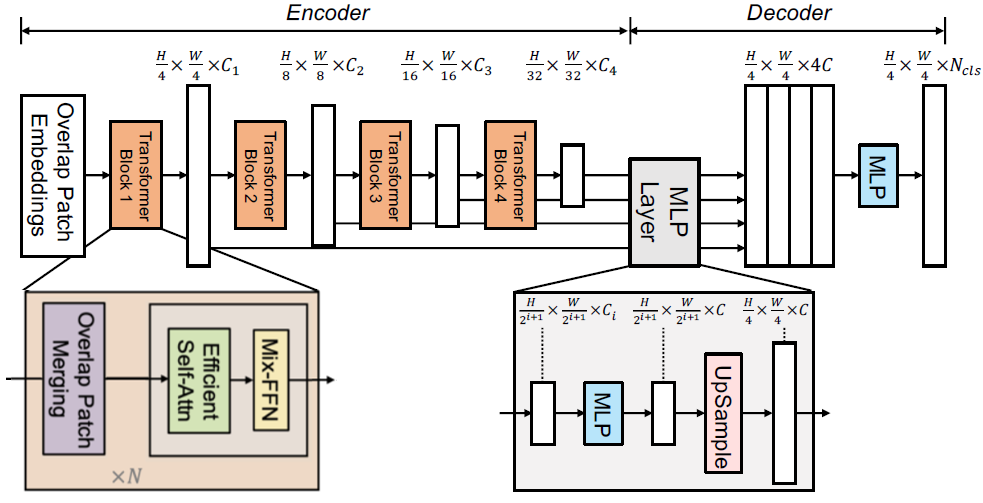

[Image reference](https://arxiv.org/abs/2105.15203)

## Imports & Download

In [ ]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting
import cv2
import matplotlib.pyplot as plt

In [ ]:
try:
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

except:
    !pip install timm
    !pip install einops
    !pip install segmentation-models-pytorch

    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

**First, download the Dataset.**
<p>The dataset is about 3GB big, and training might take forever on Colab. You can try it, but I put it separately from the other files.

In [ ]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/archive.zip && unzip archive.zip

**Then, download the trained weights (500Mb)**<p>
If you don't want to train forever or download 3GB of data, you can also directly load the inference files. We have several of them:

*   **MIT B3 ImageNet Weights** — a network already trained on imagenet, that we can use for training (transfer learning)
*   **MIT B2 and B3** (full model trained on drivable area detection // other segformer workshop)
*   **MIT B3 CS Pretrain 19CLS_512_1024_CE_LOSS** — The full trained (on Cityscapes) model we'll use in this notebook

If you can, I recommend you download the data + the models and helper code.

In [ ]:
#!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/cityScapes_utils.py && wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/utils.py

In [ ]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/segformers.zip && unzip segformers.zip

In [ ]:
!mv segformers/* .

## 1. Dataset : Download and use Cityscapes dataset

In [ ]:
targetWidth = 1024
targetHeight = 512

In [ ]:
# utility functions to get Cityscapes Pytorch dataset and dataloaders
from utils import get_dataloaders
from cityScapes_utils import get_cs_datasets

train_set, val_set, test_set= get_cs_datasets(rootDir='')
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)#, batch_size=4)

There are 2380 train images, 595 validation images, 500 test Images
Input shape = torch.Size([3, 512, 1024]), output label shape = torch.Size([512, 1024])


### Show Sample images from dataset

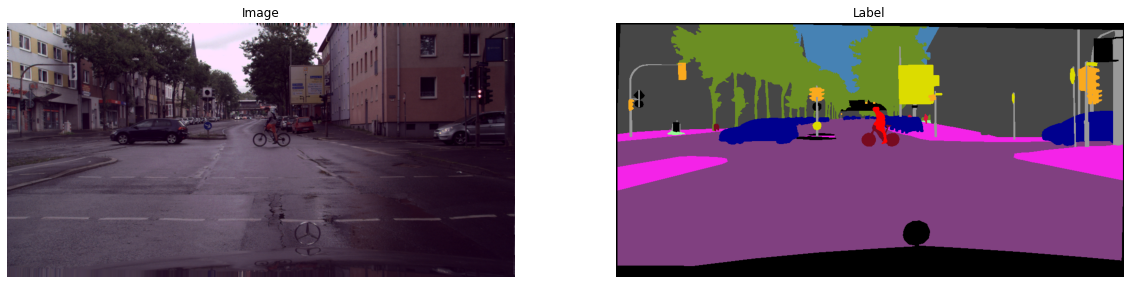

In [ ]:
from utils import inverse_transform
from cityScapes_utils import train_id_to_color as cs_train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(cs_train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

## 2 — Segformer Network
The Segformer is made of 2 parts: An Encoder and a Decoder. Let's begin with the Encoder, also called Mix Transformer.

### Mix Transformer / Encoder

First, we'll gather the ingredients from a single transformer stage:

*   Overlap Patch Embedding
*   Efficient Self-Attention
*   Mix FFNs

**The 3 elements form a single Transformer Block.**



In [ ]:
class overlap_patch_embed(nn.Module):
    def __init__(self, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size // 2, patch_size // 2))
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        _, _, h, w = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.norm(x)
        return x, h, w

In [ ]:
class efficient_self_attention(nn.Module):
    def __init__(self, attn_dim, num_heads, dropout_p, sr_ratio):
        super().__init__()
        assert attn_dim % num_heads == 0, f'expected attn_dim {attn_dim} to be a multiple of num_heads {num_heads}'
        self.attn_dim = attn_dim
        self.num_heads = num_heads
        self.dropout_p = dropout_p
        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(attn_dim, attn_dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(attn_dim)

        # Multi-head Self-Attention using dot product
        # Query - Key Dot product is scaled by root of head_dim
        self.q = nn.Linear(attn_dim, attn_dim, bias=True)
        self.kv = nn.Linear(attn_dim, attn_dim * 2, bias=True)
        self.scale = (attn_dim // num_heads) ** -0.5

        # Projecting concatenated outputs from
        # multiple heads to single `attn_dim` size
        self.proj = nn.Linear(attn_dim, attn_dim)


    def forward(self, x, h, w):
        q = self.q(x)
        q = rearrange(q, ('b hw (m c) -> b m hw c'), m=self.num_heads)

        if self.sr_ratio > 1:
            x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
            x = self.sr(x)
            x = rearrange(x, 'b c h w -> b (h w) c')
            x = self.norm(x)

        x = self.kv(x)
        x = rearrange(x, 'b d (a m c) -> a b m d c', a=2, m=self.num_heads)
        k, v = x[0], x[1] # x.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = attn @ v
        x = rearrange(x, 'b m hw c -> b hw (m c)')
        x = self.proj(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x

In [ ]:
class mix_feedforward(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, dropout_p = 0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)

        # Depth-wise separable convolution
        self.conv = nn.Conv2d(hidden_features, hidden_features, (3, 3), padding=(1, 1),
                              bias=True, groups=hidden_features)
        self.dropout_p = dropout_p

    def forward(self, x, h, w):
        x = self.fc1(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.conv(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = F.gelu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x


In [ ]:
class transformer_block(nn.Module):
    def __init__(self, dim, num_heads, dropout_p, drop_path_p, sr_ratio):
        super().__init__()
        # One transformer block is defined as :
        # Norm -> self-attention -> Norm -> FeedForward
        # skip-connections are added after attention and FF layers
        self.attn = efficient_self_attention(attn_dim=dim, num_heads=num_heads,
                    dropout_p=dropout_p, sr_ratio=sr_ratio)
        self.ffn = mix_feedforward( dim, dim, hidden_features=dim * 4, dropout_p=dropout_p)

        self.drop_path_p = drop_path_p
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)


    def forward(self, x, h, w):
        # Norm -> self-attention
        skip = x
        x = self.norm1(x)
        x = self.attn(x, h, w)
        x = drop_path(x, drop_prob=self.drop_path_p, training=self.training)
        x = x + skip

        # Norm -> FeedForward
        skip = x
        x = self.norm2(x)
        x = self.ffn(x, h, w)
        x = drop_path(x, drop_prob=self.drop_path_p, training=self.training)
        x = x + skip
        return x

Then, we'll build a set of transformer stages: each stage is Nx Transformer Blocks:

In [ ]:
class mix_transformer_stage(nn.Module):
    def __init__(self, patch_embed, blocks, norm):
        super().__init__()
        self.patch_embed = patch_embed
        self.blocks = nn.ModuleList(blocks)
        self.norm = norm

    def forward(self, x):
        x, h, w = self.patch_embed(x)
        for block in self.blocks:
            x = block(x, h, w)
        x = self.norm(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return x

Finally, we create the full decoder, which is a set of 4 consecutive transformer stages (what's incorrectly called "block" in the image). **Each Transformer Stage is made of Nx Transformer Blocks.** Each block is made of Efficient Self-Attention, Mix FFNs, and Overlap Patch Merging.

In [ ]:
class mix_transformer(nn.Module):
    def __init__(self, in_chans, embed_dims, num_heads, depths,
                sr_ratios, dropout_p, drop_path_p):
        super().__init__()
        self.stages = nn.ModuleList()
        for stage_i in range(len(depths)):
            # Each Stage consists of following blocks :
            # Overlap patch embedding -> mix_transformer_block -> norm

            ## TODO: Create a New Block
            pass

            if(stage_i == 0):
                patch_size = #TODO
                stride = #TODO
                in_chans = #TODO
            else:
                patch_size = #TODO
                stride = #TODO
                in_chans = #TODO

            patch_embed = #TODO
            norm = nn.LayerNorm(embed_dims[stage_i], eps=1e-6)
            self.stages.append(mix_transformer_stage(patch_embed, blocks, norm))


    def forward(self, x):
        outputs = []
        for stage in self.stages:
            x = stage(x)
            outputs.append(x)
        return outputs

### Decoder Head

In [ ]:
class segformer_head(nn.Module):
    def __init__(self, in_channels, num_classes, embed_dim, dropout_p=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.dropout_p = dropout_p

        # 1x1 conv to fuse multi-scale output from encoder
        self.layers = nn.ModuleList([nn.Conv2d(chans, embed_dim, (1, 1))
                                     for chans in reversed(in_channels)])
        self.linear_fuse = nn.Conv2d(embed_dim * len(self.layers), embed_dim, (1, 1), bias=False)
        self.bn = nn.BatchNorm2d(embed_dim, eps=1e-5)

        # 1x1 conv to get num_class channel predictions
        self.linear_pred = nn.Conv2d(self.embed_dim, num_classes, kernel_size=(1, 1))
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.linear_fuse.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature_size = x[0].shape[2:]

        # project each encoder stage output to H/4, W/4
        pass

        # concatenate project output and use 1x1
        # convs to get num_class channel output
        pass
        #TODO

        return x

### Full Segformer

In [ ]:
class segformer_mit_b3(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Encoder block
        self.backbone = mix_transformer(in_chans=in_channels, embed_dims=(64, 128, 320, 512),
                                    num_heads=(1, 2, 5, 8), depths=(3, 4, 18, 3),
                                    sr_ratios=(8, 4, 2, 1), dropout_p=0.0, drop_path_p=0.1)
        # decoder block
        self.decoder_head = segformer_head(in_channels=(64, 128, 320, 512),
                                    num_classes=num_classes, embed_dim=256)

        # init weights
        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")


    def forward(self, x):
        image_hw = x.shape[2:]
        x = #TODO: Call Encoder
        x = #TODO: Call Decoder
        x = #TODO: Interpolate to output size
        return x

## 3. Training : Train and validate model on the custom dataset


We will reuse the utility functions we defined in FCN notebook

In [ ]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

### Model Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MODEL HYPERPARAMETERS
N_EPOCHS = 12
NUM_CLASSES = 19
MAX_LR = 1e-3
MODEL_NAME = f'segformer_mit_b3_cs_pretrain_19CLS_{targetHeight}_{targetWidth}_CE_loss'

import os
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
# criterion = smp.losses.DiceLoss('multiclass', classes=np.arange(20).tolist(), log_loss = True, smooth=1.0)
criterion = nn.CrossEntropyLoss(ignore_index=19)

# create model, load imagenet pretrained weights
model = segformer_mit_b3(in_channels=3, num_classes=NUM_CLASSES).to(device)
model.backbone.load_state_dict(torch.load('segformer_mit_b3_imagenet_weights.pt', map_location=device))

<All keys matched successfully>

In [ ]:
# create optimizer, lr_scheduler and pass to training function
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = "")

Starting 1 epoch ...


  0%|          | 0/297 [00:00<?, ?it/s]

## 4. Evaluate : Evaluate the model on Test Data and visualize results

In [ ]:
model.load_state_dict(torch.load(f'{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


Model has 0.701119476182295 mean IoU in test set


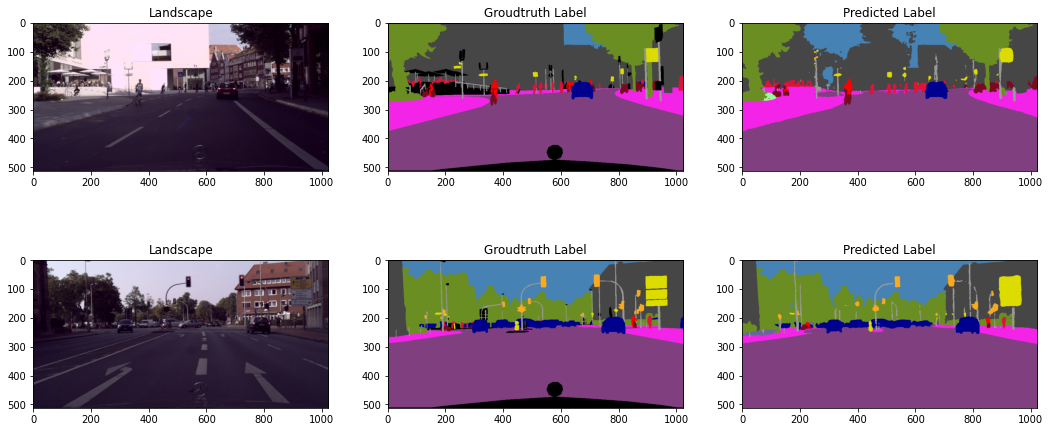

In [ ]:
from utils import visualize_predictions
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples,
                      id_to_color = cs_train_id_to_color)

## Test on sample video

In [ ]:
import os
from tqdm import tqdm
from utils import preprocess

def predict_cs_video(model, model_name, demo_video_path, id_to_color,
                     output_dir, target_width, target_height, device,
                    fps : int = 20, alpha : float = 0.3):

    test_images = [os.path.join(demo_video_path, *[x]) for x in sorted(os.listdir(demo_video_path))]

    output_filename = f'{model_name}_cs_part_overlay_demo_video.avi'
    output_video_path = os.path.join(output_dir, *[output_filename])

    # handles for input output videos
    output_handle = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), \
                                    20, (target_width, target_height))

    # create progress bar
    num_frames = int(len(test_images))
    pbar = tqdm(total = num_frames, position=0, leave=True)

    for i in range(num_frames):
        frame = cv2.imread(test_images[i])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # create torch tensor to give as input to model
        pt_image = preprocess(frame)
        pt_image = pt_image.to(device)

        # get model prediction and remap certain labels to showcase
        # only certain colors. class index 19 has color map (0,0,0),
        # so remap unwanted classes to 19
        y_pred = torch.argmax(model(pt_image.unsqueeze(0)), dim=1).squeeze(0)
        predicted_labels = y_pred.cpu().detach().numpy()
        predicted_labels[(predicted_labels < 11) & (predicted_labels != 0) & (predicted_labels != 6) & (predicted_labels != 7)] = 19

        # convert to corresponding color
        cm_labels = (id_to_color[predicted_labels]).astype(np.uint8)

        # overlay prediction over input frame
        overlay_image = cv2.addWeighted(frame, 1, cm_labels, alpha, 0)
        overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR)

        # write output result and update progress
        output_handle.write(overlay_image)
        pbar.update(1)


    output_handle.release()

In [ ]:
predict_cs_video(model, MODEL_NAME,
                 demo_video_path = 'demoVideo/stuttgart_00',
                 id_to_color = cs_train_id_to_color,
                 output_dir = '.',
                 target_width = targetWidth,
                 target_height = targetHeight,
                 device = device,
                 alpha=0.7)

100%|██████████| 599/599 [01:28<00:00,  6.76it/s]
